In [8]:
%matplotlib inline
%load_ext nb_black
import sys
from itertools import groupby
from pdb import set_trace

import pandas as pd
from scipy.optimize import minimize, brute, fmin
from random import random, randint, choice
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


def array_softmax(Q, T):
    """Array based calculation of softmax probabilities for binary choices.
    Q: Action values - array([n_trials,2])
    T: Inverse temp  - float."""
    P = np.zeros(Q.shape)
    TdQ = -T * (Q[:, 0] - Q[:, 1])
    TdQ[
        TdQ > LOG_MAX_FLOAT
    ] = LOG_MAX_FLOAT  # Protection against overflow in exponential.
    P[:, 0] = 1.0 / (1.0 + np.exp(TdQ))
    P[:, 1] = 1.0 - P[:, 0]
    return P


def protected_log(x):
    "Return log of x protected against giving -inf for very small values of x."
    return np.log(((1e-200) / 2) + (1 - (1e-200)) * x)


def choose(P):
    "Takes vector of probabilities P summing to 1, returns integer s with prob P[s]"
    return sum(np.cumsum(P) < random())


def softmax(Q, T):
    "Softmax choice probs given values Q and inverse temp T."
    QT = Q * T
    QT[
        QT > LOG_MAX_FLOAT
    ] = LOG_MAX_FLOAT  # Protection against overflow in exponential.
    expQT = np.exp(QT)
    return expQT / expQT.sum()


def session_likelihood(params, return_q=False):
    # Unpack trial events.
    choices, second_steps, outcomes = (
        results["choices"].astype(int),
        results["second_steps"].astype(int),
        results["outcomes"].astype(int),
    )
    # Unpack parameters.
    alpha_td, b1, b2, b3 = params
    alpha_qlearning = b4 = 0
    #     alpha_qlearning, b2, b3, b4 = params
    #     alpha_td = b1 = 0
    #     alpha_td, alpha_qlearning, b1, b2, b3, b4 = params
    iTemp = 1

    # Variables.
    Q_td = np.zeros([2, 1, 2])  # Indicies: action, prev. second step., prev outcome
    Q_qlearning = np.zeros([2, 1, 2])

    Q_td2 = np.zeros([n_trials, 2])  # Active action values.
    Q_qlearning2 = np.zeros([n_trials, 2])
    Q_bias = np.ones([n_trials, 2])  # bias agent.

    ps = 0  # previous second step.
    #         po = randint(0, 1)  # previous outcome.
    po = 0
    for i, (c, s, o) in enumerate(
        zip(choices, second_steps, outcomes)
    ):  # loop over trials.

        Q_td2[i, 0] = Q_td[0, ps, po]
        Q_td2[i, 1] = Q_td[1, ps, po]

        Q_qlearning2[i, 0] = Q_qlearning[0, ps, po]
        Q_qlearning2[i, 1] = Q_qlearning[1, ps, po]

        # update action values.
        Q_td[c, ps, po] = (1.0 - alpha_td) * Q_td[c, ps, po] + alpha_td * o
        Q_qlearning[c, ps, po] = Q_qlearning[c, ps, po] + alpha_qlearning * (
            o - Q_qlearning[c, ps, po]
        )

        ps, po = s, o

    Q_psv = np.array(
        [
            np.array([1, 0]) if i == 0 else np.array([0, 1])
            for i in np.roll(results["choices"], 1)
        ]
    )
    Q_psv[0, :] = np.array([0, 0])
    for i in range(n_trials):
        Q_bias[i, randint(0, 1)] = -1

    # Evaluate choice probabilities and likelihood.
    Q = b1 * Q_td2 + b2 * Q_psv + b3 * Q_bias + b4 * Q_qlearning2
    choice_probs = array_softmax(Q, iTemp)
    trial_log_likelihood = protected_log(choice_probs[np.arange(n_trials), choices])
    session_log_likelihood = np.sum(trial_log_likelihood)
    if return_q:
        return -session_log_likelihood, Q
    else:
        return -session_log_likelihood


def simulate(params, r_states, n_trials, rprob):

    alpha_td, b1, b2, b3 = params
    alpha_qlearning = b4 = 0
    #     alpha_qlearning, b2, b3, b4 = params
    #     alpha_td = b1 = 0
    #     alpha_td, alpha_qlearning, b1, b2, b3, b4 = params
    iTemp = 1

    Q_td = np.zeros([2, 1, 2])  # Indicies: action, prev. second step., prev outcome
    Q_qlearning = np.zeros([2, 1, 2])

    Q_td2 = np.zeros([n_trials, 2])
    Q_qlearning2 = np.zeros([n_trials, 2])
    choices, second_steps, outcomes = (
        np.zeros(n_trials, int),
        np.zeros(n_trials, int),
        np.zeros(n_trials, int),
    )

    ps = 0  # previous second step.
    #         po = randint(0, 1)  # previous outcome.
    po = 0

    for i in range(n_trials):
        #             set_trace()
        Q_td2[i, 0] = Q_td[0, ps, po]
        Q_td2[i, 1] = Q_td[1, ps, po]

        Q_qlearning2[i, 0] = Q_qlearning[0, ps, po]
        Q_qlearning2[i, 1] = Q_qlearning[1, ps, po]
        # Generate trial events.
        if i == 0:
            c = choose(
                softmax(
                    (
                        b1 * Q_td[:, ps, po]
                        + b2 * randint(0, 1)
                        + b3 * randint(-1, 1)
                        + b4 * Q_qlearning[:, ps, po]
                    ),
                    iTemp,
                )
            )
        else:
            c = choose(
                softmax(
                    (
                        b1 * Q_td[:, ps, po]
                        + b2 * int(c == choices[i - 1])
                        + b3 * randint(-1, 1)
                        + b4 * Q_qlearning[:, ps, po]
                    ),
                    iTemp,
                )
            )
        s = 0
        o = int(random() <= rprob) if c == r_states[i] else int(random() > rprob)

        # update action values.
        Q_td[c, ps, po] = (1.0 - alpha_td) * Q_td[c, ps, po] + alpha_td * o
        Q_qlearning[c, ps, po] = Q_qlearning[c, ps, po] + alpha_qlearning * (
            o - Q_qlearning[c, ps, po]
        )
        ps, po = s, o

        choices[i], second_steps[i], outcomes[i] = (c, s, o)

    return choices, second_steps, outcomes, Q_td2, Q_qlearning2


def before_after_chg_accuracy(results, choices_pred):
    results = results.assign(choices_pred=choices_pred)
    """where states change"""
    change_index = (
        (results.r_state != results.r_state.shift())
        .where(lambda x: x == True)
        .dropna()
        .index[1:]
    )

    """get 20 indices before and after change index"""
    buffer_length = 20
    before_after_chgs = pd.DataFrame(
        [
            [
                results.loc[i, "r_state"],
                results.loc[
                    i - buffer_length : i + buffer_length, ["choices", "choices_pred"]
                ]
                .apply(lambda x: x.values[0] == x.values[1], 1)
                .values.ravel(),
            ]
            for i in change_index
        ],
        columns=["to_state", "accuracy"],
    )

    before_after_chgs = before_after_chgs[
        before_after_chgs.accuracy.apply(len) == 1 + buffer_length * 2
    ]
    """plot"""
    plt.figure(figsize=(15, 3))
    plt.plot(np.vstack(before_after_chgs.accuracy).mean(0))
    plt.xticks(
        ticks=range(1 + buffer_length * 2),
        labels=np.arange(-buffer_length, buffer_length + 1),
    )
    plt.xlabel("before or after change points (0 is the start of the later state)")
    plt.ylabel("average accuracy")
    plt.title(label="before and after state transition accuracy")


def do_logistic_regression(L, rwds, actions, ax, method="rwd_choice"):
    if method == "rwd_choice":
        data = (
            pd.concat(
                [
                    pd.Series(rwds * actions).shift(i).rename("last" + str(i))
                    for i in range(1, L)
                ],
                1,
            )
            .assign(y=actions)
            .dropna()
        )
    if method == "rwd":
        data = (
            pd.concat(
                [pd.Series(rwds).shift(i).rename("last" + str(i)) for i in range(1, L)],
                1,
            )
            .assign(y=actions)
            .dropna()
        )
    if method == "choice":
        data = (
            pd.concat(
                [
                    pd.Series(actions).shift(i).rename("last" + str(i))
                    for i in range(1, L)
                ],
                1,
            )
            .assign(y=actions)
            .dropna()
        )

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = LogisticRegression(class_weight="balanced")
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    print("accuracy:", accuracy_score(y_test, pred))
    pd.DataFrame(model.coef_, columns=X.columns).T.rename(columns={0: "weight"}).plot(
        ax=ax, marker="o"
    )


LOG_MAX_FLOAT = np.log(sys.float_info.max / 2.1)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

trial length: 1277
current reward probability: 0.8
reward states and each block length:
     r_state  state_length
0       1.0            66
1       0.0            58
2       1.0            96
3       0.0            52
4       1.0            79
5       0.0            52
6       1.0            50
7       0.0            50
8       1.0            50
9       0.0            77
10      1.0            50
11      0.0            50
12      1.0            54
13      0.0            60
14      1.0            52
15      0.0            67
16      1.0            50
17      0.0            50
18      1.0            50
19      0.0            50
20      1.0            51
21      0.0            63
Iteration limit reached    (Exit mode 9)
            Current function value: 508.6359290427155
            Iterations: 100
            Function evaluations: 1475
            Gradient evaluations: 99
fitted: [5.25423347e-01 2.08871660e+00 9.61341742e-01 4.50955676e-07]
likelihood: 508.6359413408147
prediction acc

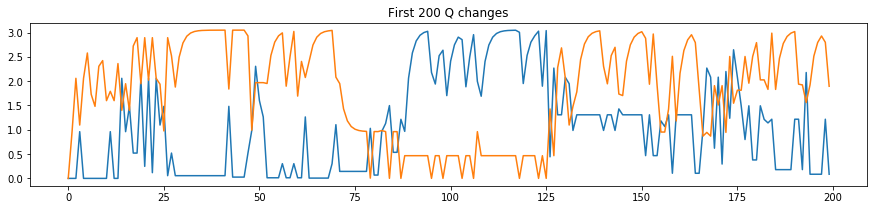

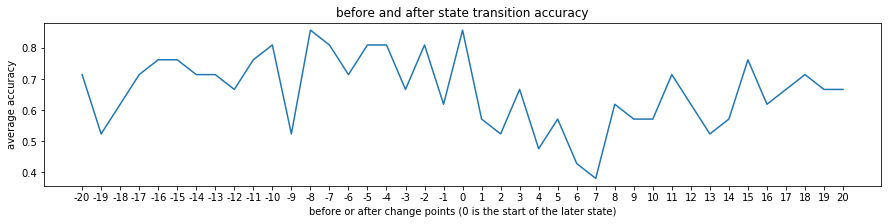

<IPython.core.display.Javascript object>

In [9]:
"""read data"""
df = (
    pd.read_csv("xieyang_behaviordata.csv")
    .rename(columns={"c_cue": "choices", "rwd_fed": "outcomes"})
    .assign(second_steps=0)
)
results = df[df.file == "M150241_session6_bhv_ana.mat"].replace(-1, 0)
n_trials = results.shape[0]

print("trial length:", n_trials)
print("current reward probability:", results.rprob.unique()[0])
print(
    "reward states and each block length:\n",
    pd.DataFrame(
        [[idx, len(list(item))] for idx, item in groupby(results.r_state)],
        columns=["r_state", "state_length"],
    ),
)

"""fit the parameters"""
initial = brute(
    session_likelihood,
    ranges=(
        slice(0, 1, 0.1),
        #         slice(0, 1, 0.1),
        #         slice(0, 10, 1),
        slice(0, 10, 1),
        slice(0, 10, 1),
        slice(0, 10, 1),
    ),
    finish=fmin,
    workers=-1,
)
res = minimize(
    session_likelihood,
    x0=initial,
    method="SLSQP",
    bounds=[(0, 1), (0, None), (0, None), (0, None)],
    options={"eps": 0.1, "disp": True, "ftol": 1e-10},
)
print("fitted:", res.x)

"""check likelihood and Q"""
likelihood, Q = session_likelihood(res.x, True)
print("likelihood:", likelihood)

plt.figure(figsize=(15, 3))
plt.plot(Q[:200])
plt.title("First 200 Q changes")

"""predict choice using fitted parameters"""
(
    choices_pred,
    second_steps_pred,
    outcomes_pred,
    Q_td2_pred,
    Q_qlearning2_pred,
) = simulate(res.x, results.r_state.values, n_trials, results.rprob.values[0])

print("prediction accuracy:", (choices_pred == results.choices).mean())

before_after_chg_accuracy(results, choices_pred)

accuracy: 0.7112860892388452
accuracy: 0.5091863517060368
accuracy: 0.6955380577427821
accuracy: 0.7900262467191601
accuracy: 0.5065616797900262
accuracy: 0.8162729658792651


/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

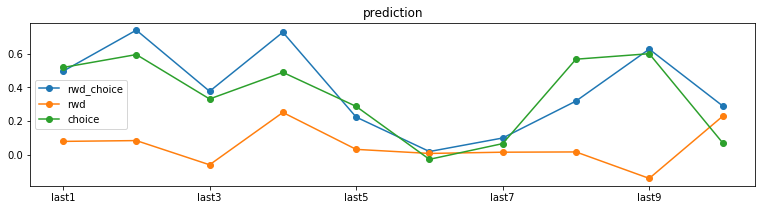

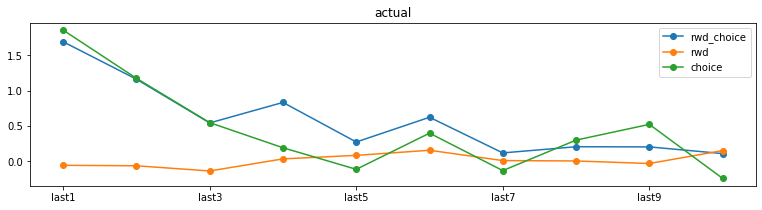

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=(13, 3))
ax.set_title("prediction")
for i in ["rwd_choice", "rwd", "choice"]:
    do_logistic_regression(11, outcomes_pred, choices_pred, ax, i)
plt.legend(["rwd_choice", "rwd", "choice"])

fig, ax = plt.subplots(figsize=(13, 3))
ax.set_title("actual")
for i in ["rwd_choice", "rwd", "choice"]:
    do_logistic_regression(11, results.outcomes.values, results.choices.values, ax, i)
plt.legend(["rwd_choice", "rwd", "choice"])